# Sentiment Analysis med scikit-learn

Denne notebooken er en enkel versjon av en sentiment-analysen 

Mål:
1. Importere og sette opp miljø
2. Laste inn IMDB-datasettet (filmreviews med positiv/negativ label) og dele det opp i train / val / test
3. Gjøre tekst om til tall med TF–IDF
4. Trene en klassisk ML-modell (Logistic Regression)
5. Evaluere modellen
6. Lage en funksjon for å klassifisere nye tekster
7. Lagre modell og vektorisering

NB: Du trenger internettilgang første gang for å hente datasettet fra Hugging Face.


In [ ]:
# Installer avhengigheter ved behov (kjør kun hvis du ikke har dem fra før)
# Oppgadeget at moderne python 3.14 ikke tillater bruken av datasets import, men kjører i python 3.12  

# !pip install datasets scikit-learn matplotlib seaborn


## 1. Importer bibliotekene

Biblokteker vi bruker:
- `datasets` henter IMDB-datasettet fra Hugging Face
- `TfidfVectorizer` gjør tekst → tall 
- `LogisticRegression` klassifikasjonsmodellen vi bruker
- `accuracy_score` osv brukes til å måle kvaliteten
- `matplotlib` / `seaborn` brukes til plotting og analyse 



In [ ]:
from datasets import load_dataset

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


import matplotlib.pyplot as plt
import seaborn as sns

# Lagt til for å kunne kjøre og teste python versjon i lokalt miljø, kanskje ikke nødvendig lengre 
import sys
print(sys.version)


c:\Users\mvp20\OneDrive\Dokumenter\Sentiment-analyse\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]


## 2. Laste inn datasettet og bygge train / val / test 

IMDB har:
- 25k train
- 25k test
- 50k unsupervised (Ikke brukt i oppgaven, men greit å vite)

Datasett: https://huggingface.co/datasets/stanfordnlp/imdb

Deler inn datasettet i trening, validering og testing: 
- Train = 25k (original train)
- Validation = 5k (20% av det opprinnelige testsettet)
- Test = 20k (resten av testsettet)

`SEED` gjør at vi får samme split hver gang (reproduserbarhet)


In [ ]:
SEED = 420
VAL_SIZE = 0.2  # 20%

# Last datasettet (tekst + label)
raw_train = load_dataset("stanfordnlp/imdb", split="train" )
raw_test  = load_dataset("stanfordnlp/imdb", split="test")
# Splitter testsettet til validering og testesting
_temp = raw_test.train_test_split(test_size=1-VAL_SIZE, seed=SEED)
raw_test_final = _temp["test"]   # 80% av det opprinnelige testsettet
raw_val_final  = _temp["train"]  # 20% av det opprinnelige testsettet

print("Train size:      ", len(raw_train))
print("Validation size: ", len(raw_val_final))
print("Test size:       ", len(raw_test_final))


Train size:       25000
Validation size:  5000
Test size:        20000


## 3. Konverter til rene Python-lister

scikit-learn forventer lister av tekster (`X`) og lister av labels (`y`).
Vi pakker ut `text` og `label` fra datastrukturene til Hugging Face.


In [4]:
X_train_texts = raw_train["text"]
y_train_labels = raw_train["label"]

X_val_texts = raw_val_final["text"]
y_val_labels = raw_val_final["label"]

X_test_texts = raw_test_final["text"]
y_test_labels = raw_test_final["label"]

print("Eksempel tekst:", X_train_texts[0][:200].replace("\n", " "), "...")
print("Label:", y_train_labels[0])


Eksempel tekst: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev ...
Label: 0


## 3.1 Lag tekst → tall representasjon (TF–IDF)

TF–IDF gjør to ting:
1. Teller ord og korte fraser (n-gram)
2. Vekter dem etter hvor typiske / unike de er

Parametere vi bruker:
- `lowercase=True`: alt til små bokstaver
- `stop_words="english"`: fjerner fyllord som "the", "and"
- `max_features=20000`: begrens ordforrådet for å spare minne
- `ngram_range=(1,2)`: ta med både enkeltord ("boring") og to-ords fraser ("not good"), som er viktig for sentiment


In [5]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=20000,
    ngram_range=(1, 2)  # både 1-gram og 2-gram
)

# Lær ordforrådet og TF–IDF-vektene fra treningssettet
X_train_vec = vectorizer.fit_transform(X_train_texts)

# Bruk samme ordforråd på val/test (NB: IKKE fit() igjen!)
X_val_vec = vectorizer.transform(X_val_texts)
X_test_vec = vectorizer.transform(X_test_texts)

print("Train vector shape:", X_train_vec.shape)
print("Val vector shape:  ", X_val_vec.shape)
print("Test vector shape: ", X_test_vec.shape)


Train vector shape: (25000, 20000)
Val vector shape:   (5000, 20000)
Test vector shape:  (20000, 20000)


### Teste inndelinge

Tillater testing av tall representasjoner på en mindre skala 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

docs = ["I didn’t like this movie", "This movie was amazing", "Not a good movie", "I loved the film"]
vectorizer_test = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2))
X = vectorizer_test.fit_transform(docs)

print(vectorizer_test.get_feature_names_out()[:1000])  # første 10 features
print(X.toarray()[0])  # vektorer for første dokument

['amazing' 'didn' 'didn like' 'film' 'good' 'good movie' 'like'
 'like movie' 'loved' 'loved film' 'movie' 'movie amazing']
[0.         0.47633035 0.47633035 0.         0.         0.
 0.47633035 0.47633035 0.         0.         0.30403549 0.        ]


## 4. Tren klassifikasjonsmodellen (Logistic Regression)

Denne modellen lærer sammenhengen mellom hvilke ord/fraser som dukker opp
og om anmeldelsen er positiv (1) eller negativ (0).

`max_iter=1000` gir den nok tid til å konvergere.


In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train_labels)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 5. Evaluer på valideringssettet

Valideringssettet brukes under utvikling for å se hvor bra modellen gjør det,
uten å røre testsettet ennå.


In [9]:
val_pred = model.predict(X_val_vec)
val_acc = accuracy_score(y_val_labels, val_pred)

print("Validation accuracy:", val_acc)
print(classification_report(y_val_labels, val_pred, target_names=["neg", "pos"]))


Validation accuracy: 0.888
              precision    recall  f1-score   support

         neg       0.90      0.88      0.89      2513
         pos       0.88      0.90      0.89      2487

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



## 5.1 Evaluer på testsettet (endelig kvalitet)

Nå sjekker vi ytelsen på testsettet, som vi ikke har brukt til trening eller tuning.
Dette gir en ærlig sluttscore.


In [10]:
test_pred = model.predict(X_test_vec)
test_acc = accuracy_score(y_test_labels, test_pred)

print("Test accuracy:", test_acc)
print(classification_report(y_test_labels, test_pred, target_names=["neg", "pos"]))


Test accuracy: 0.88125
              precision    recall  f1-score   support

         neg       0.88      0.88      0.88      9987
         pos       0.88      0.88      0.88     10013

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



### 5.2 Confusion matrix

Confusion matrix viser hvor ofte modellen tar feil per klasse.
- True Negatives / True Positives = riktig
- False Negatives / False Positives = feil

Fint å plotte i seaborn som et "heatmap".


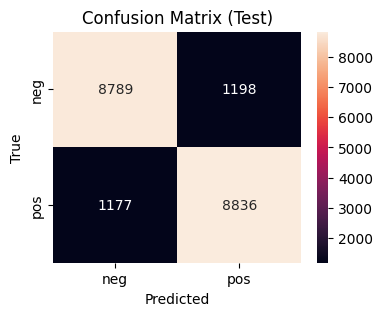

In [11]:
cm = confusion_matrix(y_test_labels, test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["neg","pos"],
            yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()


## 6. Funksjon for å klassifisere nye tekster for testing

Denne funksjonen tilsvarer `classify_review` i Transformer-notebooken din.

Vi:
1. Tar inn en ny tekststreng
2. Gjør den om til TF–IDF-vektor med **samme** vectorizer som ble trent
3. Kjører `model.predict` og `model.predict_proba`
4. Returnerer "Positive" / "Negative" + selvtillit


In [12]:
def classify_review(review_text: str):
    # Gjør tekst klar for modellen
    vec = vectorizer.transform([review_text])

    # Prediker label (0 = neg, 1 = pos)
    pred_label = model.predict(vec)[0]

    # Hent sannsynlighet hvis tilgjengelig
    try:
        proba = model.predict_proba(vec)[0]  # [p(neg), p(pos)]
        confidence = float(max(proba))
    except Exception:
        proba = None
        confidence = None

    sentiment = "Positive" if pred_label == 1 else "Negative"
    return sentiment, confidence

# Test på noen håndskrevne eksempler
examples = [
    "I absolutely loved this movie. It made me cry in a good way.",
    "What a waste of time. Boring, predictable, badly acted.",
    "It was okay I guess, not terrible but not great either. i wish it had more action and a better plot. it had some funny moments but overall it fell flat.",
]

for text in examples:
    sent, conf = classify_review(text)
    print(f"Review: {text}\n → {sent} ({conf})\n")

for text in examples:
    vec = vectorizer.transform([text])
    probs = model.predict_proba(vec)[0]
    print(f"\nReview: {text}")
    print(f" P(neg)={probs[0]:.3f}, P(pos)={probs[1]:.3f}")


Review: I absolutely loved this movie. It made me cry in a good way.
 → Positive (0.5304902815985154)

Review: What a waste of time. Boring, predictable, badly acted.
 → Positive (0.532291157301089)

Review: It was okay I guess, not terrible but not great either. i wish it had more action and a better plot. it had some funny moments but overall it fell flat.
 → Positive (0.7184250872334396)


Review: I absolutely loved this movie. It made me cry in a good way.
 P(neg)=0.470, P(pos)=0.530

Review: What a waste of time. Boring, predictable, badly acted.
 P(neg)=0.468, P(pos)=0.532

Review: It was okay I guess, not terrible but not great either. i wish it had more action and a better plot. it had some funny moments but overall it fell flat.
 P(neg)=0.282, P(pos)=0.718


In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coeffs = model.coef_[0]

top_pos_idx = np.argsort(coeffs)[-10:]
top_neg_idx = np.argsort(coeffs)[:10]

print("Sterkt positivt ladede uttrykk:", feature_names[top_pos_idx])
print("Sterkt negativt ladede uttrykk:", feature_names[top_neg_idx])

##  7. Lagre modell og vektorizer til fil


In [ ]:
#Lagre modell og vektorizer til fil


joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(model, "sentiment_model.joblib")




In [3]:
# Test på et nytt eksempel

vectorizer = joblib.load("tfidf_vectorizer.joblib")
model = joblib.load("sentiment_model.joblib")

def classify_review(review_text: str):
    vec = vectorizer.transform([review_text])
    probs = model.predict_proba(vec)[0]  # [p(neg), p(pos)]
    p_neg, p_pos = probs[0], probs[1]
    label = "Positive" if p_pos >= 0.5 else "Negative"
    return label, p_pos

print(classify_review("This movie was amazing, I loved it"))

('Positive', np.float64(0.5659162833061926))
